# Playsense-id  model training

## 1.Basic analysis

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the data folder and file path
data_folder = "../data/"
data_file = "controller_data_user1_20250307_112616.csv"
file_path = os.path.join(data_folder, data_file)

# Check if the file exists before reading
if os.path.exists(file_path):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Display the first few rows of the DataFrame
    print("First 5 rows of the dataset:")
    display(df.head())
    
    # Display summary statistics
    print("\nSummary statistics:")
    display(df.describe())
    
    # Display information about the DataFrame
    print("\nDataFrame information:")
    df.info()
else:
    print(f"Error: File not found at {file_path}")
    print("Please check if the file exists or if the path is correct.")



First 5 rows of the dataset:


,timestamp,button_press,gyro_pitch,gyro_yaw,gyro_roll,acc_x,acc_y,acc_z,user_id
0,2025-03-07T11:26:16.592564,none,0,0,0,0,0,0,user1
1,2025-03-07T11:26:16.597643,none,-491,8288,-1140,-55,-63,60,user1
2,2025-03-07T11:26:16.602667,none,-464,8259,-1143,-46,-63,64,user1
3,2025-03-07T11:26:16.606753,none,-449,8260,-1103,-36,-61,69,user1
4,2025-03-07T11:26:16.611815,none,-459,8284,-1092,-27,-60,71,user1



Summary statistics:


,gyro_pitch,gyro_yaw,gyro_roll,acc_x,acc_y,acc_z
count,6051.000000,6051.000000,6051.000000,6051.000000,6051.000000,6051.000000
mean,-236.425549,7955.655098,-1503.924475,27.447695,-5.453314,36.862502
std,1066.765135,359.150505,1111.600017,401.740601,325.274700,395.302357
min,-2716.000000,0.000000,-4226.000000,-1731.000000,-2019.000000,-2308.000000
25%,-776.000000,7897.000000,-2084.500000,-25.000000,-14.000000,-17.000000
50%,-590.000000,7994.000000,-1911.000000,2.000000,5.000000,9.000000
75%,-179.000000,8147.000000,-986.000000,35.000000,30.000000,45.000000
max,3919.000000,9395.000000,3920.000000,2089.000000,1272.000000,2163.000000



DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6051 entries, 0 to 6050
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   timestamp     6051 non-null   object
 1   button_press  6051 non-null   object
 2   gyro_pitch    6051 non-null   int64 
 3   gyro_yaw      6051 non-null   int64 
 4   gyro_roll     6051 non-null   int64 
 5   acc_x         6051 non-null   int64 
 6   acc_y         6051 non-null   int64 
 7   acc_z         6051 non-null   int64 
 8   user_id       6051 non-null   object
dtypes: int64(6), object(3)
memory usage: 425.6+ KB


Detected buttons: circle, cross, down, left, right, square, up


,button,count,avg_sequence_length,avg_duration_ms,last_press
3,up,4,34.75,168.396,2025-03-07 11:26:43.644303
1,square,2,26.00,124.262,2025-03-07 11:26:39.552093
4,down,2,29.50,141.712,2025-03-07 11:26:42.421261
5,left,2,39.00,188.871,2025-03-07 11:26:41.847694
6,right,2,31.00,149.826,2025-03-07 11:26:43.127398
0,cross,1,32.00,155.041,2025-03-07 11:26:39.999734
2,circle,1,24.00,114.504,2025-03-07 11:26:40.497528



===== Button Press Sequences =====
No button sequences detected in the data.

Most pressed button: up (4 times)
Button with longest average press: left (188.87 ms)


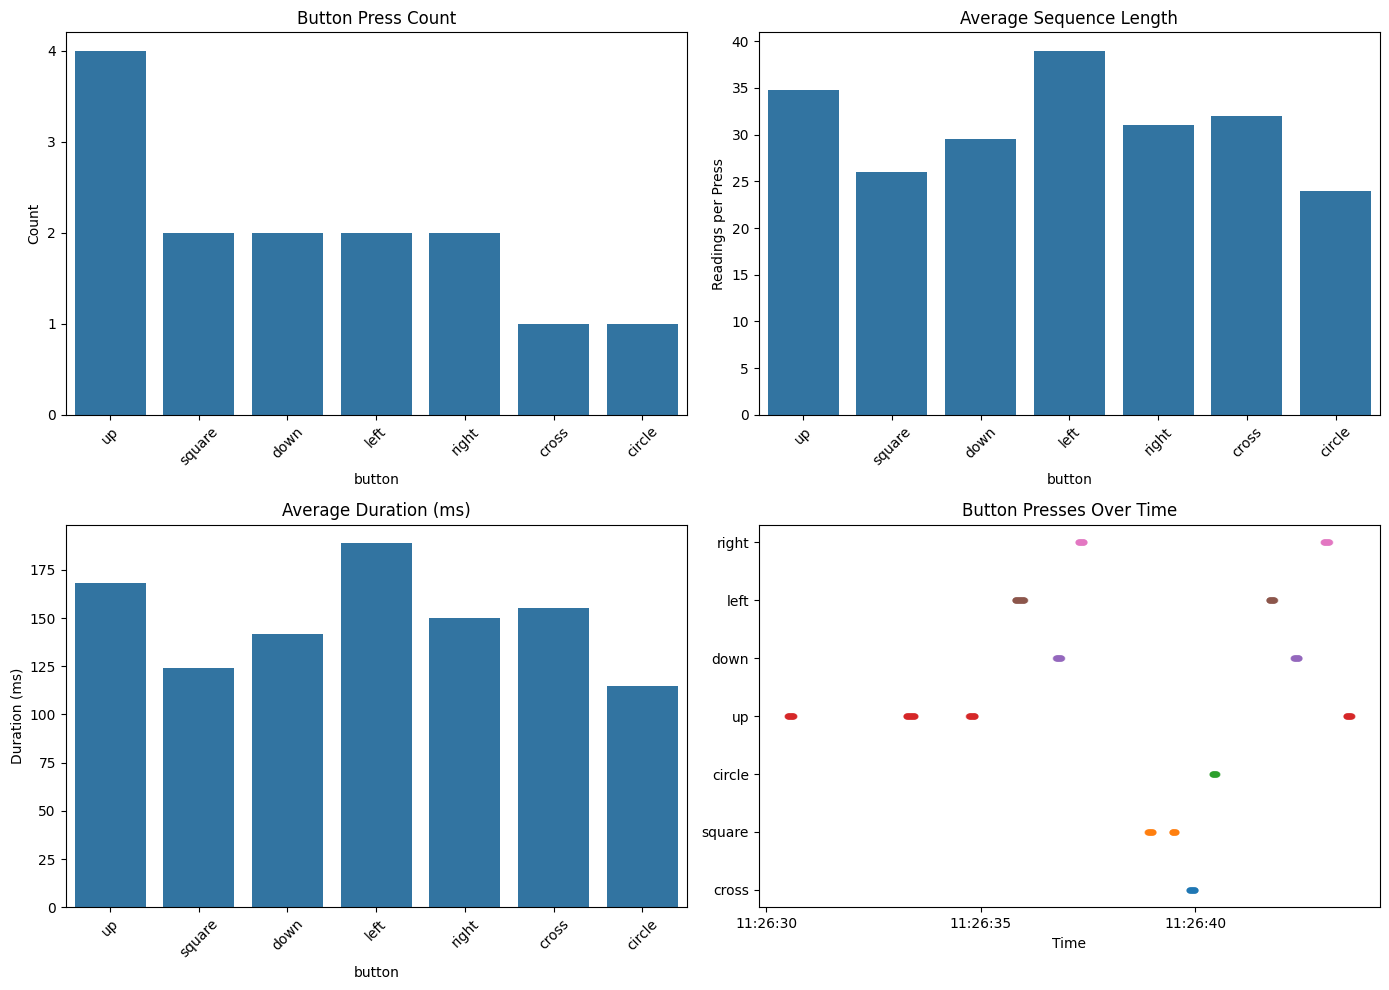

In [9]:
# Button Press Analysis
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Convert timestamp to datetime if it's not already
if df['timestamp'].dtype == 'object':
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Make a copy to avoid warnings
df_analysis = df.copy()

# Extract button events (exclude 'EVENT:' markers)
button_events = df_analysis[~df_analysis['button_press'].str.contains('EVENT:', na=False)].copy()

# Create a new column to track button state changes
button_events['prev_button'] = button_events['button_press'].shift(1)

# Find transitions (current button != previous button)
button_events['is_transition'] = button_events['button_press'] != button_events['prev_button']

# Create columns to track button press start and end
# Button press starts when state changes from 'none' to something else
button_events['press_start'] = (button_events['prev_button'] == 'none') & (button_events['button_press'] != 'none')

# Button press ends when state changes from something to 'none'
button_events['press_end'] = (button_events['prev_button'] != 'none') & (button_events['button_press'] == 'none')

# Extract all unique buttons from the data
all_buttons = set()
for buttons in button_events['button_press'].unique():
    if isinstance(buttons, str) and buttons != 'none' and not (isinstance(buttons, str) and buttons.startswith('EVENT:')):
        all_buttons.update(buttons.split(','))

print(f"Detected buttons: {', '.join(sorted(all_buttons))}")

# Count button presses (transitions from none to button)
press_starts = button_events[button_events['press_start']].copy()

button_stats = {}
for button in all_buttons:
    # Count occurrences where this button appears in button_press
    count = sum(press_starts['button_press'].str.contains(button, na=False))
    
    # Find presses containing this button
    button_presses = button_events[button_events['button_press'].str.contains(button, na=False)].copy()
    
    # Collect statistics for this button
    if not button_presses.empty:
        # Get average sequence length when this button is pressed
        # Group consecutive presses together
        button_presses.loc[:, 'group'] = (button_presses['is_transition']).cumsum()
        grouped = button_presses.groupby('group')
        avg_sequence = grouped.size().mean()
        
        # Get the last time this button was pressed
        last_press = button_presses['timestamp'].max()
        
        # Create duration column for sequences
        sequences = []
        for _, group in grouped:
            if len(group) > 1:
                # Calculate duration in milliseconds
                duration = (group['timestamp'].max() - group['timestamp'].min()).total_seconds() * 1000
                sequences.append(duration)
        
        avg_duration = np.mean(sequences) if sequences else np.nan
        
        button_stats[button] = {
            'count': count,
            'avg_sequence_length': avg_sequence,
            'avg_duration_ms': avg_duration,
            'last_press': last_press
        }

# Create a DataFrame from the button statistics for better display
stats_df = pd.DataFrame.from_dict(button_stats, orient='index')
stats_df = stats_df.reset_index().rename(columns={'index': 'button'})
stats_df = stats_df.sort_values('count', ascending=False)

# Display the statistics DataFrame
display(stats_df)

# Create visualizations
plt.figure(figsize=(14, 10))

# Button press count
plt.subplot(2, 2, 1)
sns.barplot(x='button', y='count', data=stats_df)
plt.title('Button Press Count')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Average sequence length
plt.subplot(2, 2, 2)
sns.barplot(x='button', y='avg_sequence_length', data=stats_df)
plt.title('Average Sequence Length')
plt.xticks(rotation=45)
plt.ylabel('Readings per Press')

# Average duration
plt.subplot(2, 2, 3)
sns.barplot(x='button', y='avg_duration_ms', data=stats_df)
plt.title('Average Duration (ms)')
plt.xticks(rotation=45)
plt.ylabel('Duration (ms)')

# Button press distribution over time
plt.subplot(2, 2, 4)
for button in all_buttons:
    button_df = button_events[button_events['button_press'].str.contains(button, na=False)]
    if not button_df.empty:
        plt.scatter(button_df['timestamp'], [button] * len(button_df), alpha=0.5, s=10, label=button)

plt.title('Button Presses Over Time')
plt.xlabel('Time')
plt.yticks(list(all_buttons))
plt.tight_layout()

# Calculate temporal distribution of button presses
print("\n===== Button Press Sequences =====")
sequences = button_events[button_events['button_press'] != 'none'].copy()
sequences.loc[:, 'time_diff'] = (sequences['timestamp'] - sequences['timestamp'].shift(1)).dt.total_seconds() * 1000
sequences = sequences[~sequences['prev_button'].isna()]

# Show distribution of button press sequences
common_sequences = []
for i in range(len(sequences) - 1):
    if i < len(sequences) - 1 and sequences.iloc[i]['is_transition'] and sequences.iloc[i+1]['is_transition']:
        btn1 = sequences.iloc[i]['button_press']
        btn2 = sequences.iloc[i+1]['button_press']
        time_diff = sequences.iloc[i+1]['time_diff']
        if not pd.isna(time_diff) and btn1 != 'none' and btn2 != 'none':
            common_sequences.append((btn1, btn2, time_diff))

if common_sequences:
    seq_df = pd.DataFrame(common_sequences, columns=['first_button', 'second_button', 'time_diff_ms'])
    # Display top 10 most common button sequences
    sequence_counts = seq_df.groupby(['first_button', 'second_button']).size().reset_index(name='count')
    sequence_counts = sequence_counts.sort_values('count', ascending=False).head(10)
    print("\nTop 10 Most Common Button Sequences:")
    display(sequence_counts)
    
    # Display typical timing between button presses
    timing_stats = seq_df.groupby(['first_button', 'second_button'])['time_diff_ms'].agg(['mean', 'std', 'min', 'max']).reset_index()
    timing_stats = timing_stats.sort_values('mean')
    print("\nTiming Between Button Sequences (ms):")
    display(timing_stats.head(10))
else:
    print("No button sequences detected in the data.")

# Print out the most important findings
if button_stats:
    most_pressed = max(button_stats.items(), key=lambda x: x[1]['count'])
    print(f"\nMost pressed button: {most_pressed[0]} ({most_pressed[1]['count']} times)")
    
    # Check for non-NaN values before finding the max
    valid_durations = {k: v for k, v in button_stats.items() if not np.isnan(v['avg_duration_ms'])}
    if valid_durations:
        longest_press = max(valid_durations.items(), key=lambda x: x[1]['avg_duration_ms'])
        print(f"Button with longest average press: {longest_press[0]} ({longest_press[1]['avg_duration_ms']:.2f} ms)")

## Baseline model 
- SVM

In [ ]:
# baseline model ,svm one lable model 
